Eran shmuel 301796561<br>
Eliyahu Shneider 302516463

# Init notebook data
### add our data folder to your Gdrive (its just a sharing you  can remove it afterward)
* go to this link: https://drive.google.com/drive/folders/1rD62zeFpCH7RAuNnvZubaD0oaDVK9ELX
* press on Eran_Eliyahu_cyclgan and then select add shortcut like:

   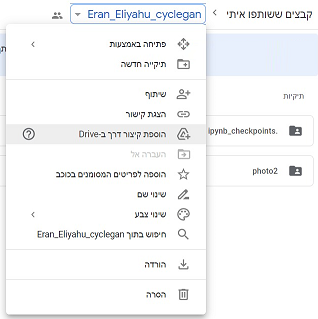
* now select MyDrive and press ADD SHORTCUT like:

   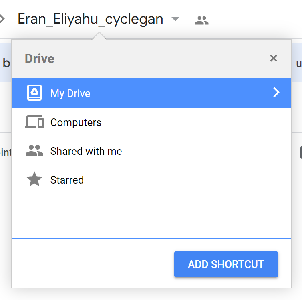
* and you are ready to go

**Imports**

In [ ]:
import os
import itertools
import random
from datetime import datetime
from pathlib import Path
import torch.backends.cudnn as cudnn
import torch.utils.data
import torchvision.transforms as transforms
from PIL import Image
from torch.utils.data import Dataset
from torchvision.utils import save_image
from tqdm import tqdm

from torch.optim.lr_scheduler import StepLR
from sys import argv
from collections import deque
from google.colab import drive
from IPython.display import Image as image_show


In [ ]:


drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Models

In [ ]:
import torch
import torch.nn as nn
import torch.nn.functional as F
padding_mode='reflect'

class Cyclegan_Generator(nn.Module):
    def __init__(self,scale=64,resnet_layers=9):
        super(Cyclegan_Generator, self).__init__()
        self.relu=nn.ReLU(inplace=True)
        self.norm1=nn.InstanceNorm2d(scale)
        self.norm2=nn.InstanceNorm2d(scale*2)
        self.norm3=nn.InstanceNorm2d(scale*4)
        self.norm4=nn.InstanceNorm2d(scale*2)
        self.norm5=nn.InstanceNorm2d(scale)
        self.conv1=nn.Conv2d(in_channels =3, out_channels=scale, kernel_size =7,padding=3,stride=1,padding_mode="reflect") 
        self.down1=nn.Conv2d(in_channels =scale, out_channels=scale*2, kernel_size =3, stride=2, padding=1,padding_mode=padding_mode)
        self.down2=nn.Conv2d(in_channels =scale*2, out_channels=scale*4, kernel_size =3, stride=2, padding=1,padding_mode=padding_mode)
        self.up1=nn.ConvTranspose2d(in_channels =scale*4, out_channels=scale*2, kernel_size =3, stride=2, padding=1,output_padding=1)
        self.up2=nn.ConvTranspose2d(in_channels =scale*2, out_channels=scale, kernel_size =3, stride=2, padding=1,output_padding=1)
        self.last_conv=nn.Conv2d(in_channels = scale, out_channels=3, kernel_size =7,padding=3,stride=1,padding_mode="reflect")
        self.tanh=nn.Tanh()    
        res_layers=[]
        self.resnet_layers=resnet_layers
        for i in range(resnet_layers):
            res_layers.append(ResBlock(channels=scale*4))
        self.res_layers=nn.ModuleList(res_layers)
    def forward(self, x):
        x=self.relu(self.norm1(self.conv1(x)))
        x=self.relu(self.norm2(self.down1(x)))
        x=self.relu(self.norm3(self.down2(x)))
        for i in range(self.resnet_layers):
            x=self.res_layers[i](x)+x
        x=self.relu(self.norm4(self.up1(x)))
        x=self.relu(self.norm5(self.up2(x))) 
        x=self.last_conv(x)
        x=self.tanh(x)
        return x
class ResBlock(nn.Module):
    def __init__(self, channels):
        super(ResBlock, self).__init__()
        self.conv1=nn.Conv2d(in_channels=channels, out_channels=channels, kernel_size=3,padding=1,stride=1,padding_mode="reflect")
        self.conv2=nn.Conv2d(in_channels=channels, out_channels=channels, kernel_size=3,padding=1,stride=1,padding_mode="reflect")
        self.relu=nn.ReLU(inplace=True)
        self.norm1=nn.InstanceNorm2d(channels)
        self.norm2=nn.InstanceNorm2d(channels)

    def forward(self, x):
        x=self.relu(self.norm1(self.conv1(x))) 
        x=self.norm2(self.conv2(x))
        return x
class Cyclegan_Discriminator(nn.Module):
    def __init__(self,scale=64):
        super(Cyclegan_Discriminator, self).__init__()
        self.lrelu=nn.LeakyReLU(0.2, inplace=True)
        self.norm2=nn.InstanceNorm2d(scale*2)
        self.norm3=nn.InstanceNorm2d(scale*4)
        self.norm4=nn.InstanceNorm2d(scale*8)
        self.conv1=nn.Conv2d(in_channels =3, out_channels=scale, kernel_size =4,stride=2,padding=1)         
        self.conv2=nn.Conv2d(in_channels =scale, out_channels=scale*2, kernel_size =4,stride=2,padding=1)         
        self.conv3=nn.Conv2d(in_channels =scale*2, out_channels=scale*4, kernel_size =4,stride=2,padding=1)         
        self.conv4=nn.Conv2d(in_channels =scale*4, out_channels=scale*8, kernel_size =4,stride=1,padding=1)         
        self.conv5=nn.Conv2d(in_channels =scale*8, out_channels=1, kernel_size =4,stride=1,padding=1)         

    def forward(self, x):
        x=self.lrelu(self.conv1(x))
        x=self.lrelu(self.norm2(self.conv2(x)))
        x=self.lrelu(self.norm3(self.conv3(x)))
        x=self.lrelu(self.norm4(self.conv4(x)))
        x=self.conv5(x)
        x = F.avg_pool2d(x, x.size()[2:])
        x = torch.flatten(x, 1)
        return x

Hyper Parameters


In [ ]:
drive_folder="/content/drive/MyDrive/Eran_Eliyahu_cyclegan/"
cudnn.benchmark = True
random.seed(100)
torch.manual_seed(100)

if torch.cuda.is_available():
    print("Using GPU.")
    device = torch.device('cuda:0')
else:
    print("Using CPU.")
    device = torch.device("cpu")
gan_alpha = 1
cycle_alpha = 10
identity_alpha = 1

image_size = 256
batch_size = 4
epochs = 50
lr = 0.0002
betas = (0.5, 0.999)
max_pools_size = 1000
save_after_how_many=1
save_image_after_how_many_iter=500
lr_decay_start=10
lr_decay_step=2
lr_gama=0.8
min_plus_resize=10
max_plus_resize=100
monet_folder="monet30"
real_folder="photo"
# pretrained model or current model if you were in the midle or training
pretrained_name="cezanne3"
model_Name="Monet_CycleGan"
# 0 or higher if you are in the middle of training
epoch_num=0
#for transfer learning only:
#bias: train only bias | one:train only the last layer | mul: train last 3 layers of generator and last 2 layers of discriminator 
#mulplus: train last 5 layers of generator and last 2 layers of discriminator #False- dont freeze
#mulsizes: train last 3 layers of generator and first 3 layers and last 2 layers of discriminator #False- dont freeze
freeze="mul"
# set to True to not freeze the bias layers
keep_bias=False


generator_class=Cyclegan_Generator
discriminator_class = Cyclegan_Discriminator


transformers={}
for i in range(min_plus_resize,max_plus_resize):
    transformers[i]= transforms.Compose([
        transforms.Resize(256+i, transforms.InterpolationMode.BICUBIC),
        transforms.RandomCrop(256),
        transforms.RandomHorizontalFlip(),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))
])

datasets_folder = Path(drive_folder)
output_folder = Path(drive_folder+'results/')
Real_Y = torch.full((batch_size, 1), 1, device=device, dtype=torch.float32)
Fake_Y = torch.full((batch_size, 1), 0, device=device, dtype=torch.float32)


Using GPU.


Functions

In [ ]:
def init_net_func(m):
    classname = m.__class__.__name__
    if classname.find("Conv") != -1:
        torch.nn.init.normal_(m.weight, 0.0, 0.02)
    elif classname.find("BatchNorm") != -1:
        torch.nn.init.normal_(m.weight, 1.0, 0.02)
        torch.nn.init.zeros_(m.bias)


def save_networks(networks_dict, networks_output_folder, checkpoint_name):
    for net_name, net in networks_dict.items():
        torch.save(net.state_dict(), f"{networks_output_folder}/{checkpoint_name}_{net_name}.pth")


def load_networks(networks_dict, networks_folder,epoch):
    if epoch>0:
      epoch_name=epoch
    else:
      epoch_name='last'
    for net_name, net in networks_dict.items():
        net.load_state_dict(torch.load(f"{networks_folder}/{epoch_name}_{net_name}.pth"))


def net_results_to_images(*net_images):
    return (0.5 * (image.detach() + 1.0) for image in net_images)


def to_device(*tensors):
    return (tensor.to(device) for tensor in tensors)

def get_dataloader():
    dataset = CycleGanDataset(datasets_folder / monet_folder, datasets_folder / real_folder)
    return torch.utils.data.DataLoader(dataset, batch_size=batch_size, shuffle=True, pin_memory=False,drop_last=True)
def freeze_model(model,freeze,keep_bias):

    if freeze!="bias":
        keep=["last_conv.weight","conv5.weight","last_conv.bias","conv5.bias"]
    else:
        keep=[]
        keep_bias=True
    add=[]
    add2=[]
    if freeze=="mul" or freeze=="mulplus" or freeze=="mulsizes":
        add=["conv4.weight","conv4.bias","up1.weight","up2.weight","up1.bias","up2.bias"]
    if freeze=="mulplus":
        add2=["res_layers.8.conv1.bias","res_layers.8.conv1.weight","res_layers.7.conv1.bias","res_layers.7.conv1.weight"]
    if freeze=="mulsizes" and  model.__class__.__name__=="Cyclegan_Generator":
        add = ["conv1.weight", "conv1.bias", "down1.weight", "down2.weight", "down1.bias", "down2.bias"]
    keep=keep+add+add2
    size = 0
    for name, param in model.named_parameters():
        if name in keep or (keep_bias and "bias" in name):
            param.requires_grad = True
            print("not frozen: "+name)
        else:
            param.requires_grad = False    

Dataset

In [ ]:
class CycleGanDataset(Dataset):
    def __init__(self, path_to_a: Path, path_to_b: Path):
        a_file_paths = list(path_to_a.iterdir())
        self.a_images=[Image.open(x).convert('RGB') for x in a_file_paths]
        b_file_paths = list(path_to_b.iterdir())
        self.b_images = [Image.open(x).convert('RGB') for x in b_file_paths]
        assert len(a_file_paths) <= len(b_file_paths)
        self.a_size=len(a_file_paths)
        self.b_size=len(b_file_paths)
        self.cant_divide=(self.b_size//self.a_size)*self.a_size
        self.ind=0
    def __getitem__(self, index):
        transform = transformers[random.randrange(min_plus_resize,max_plus_resize)]
        if index>=self.cant_divide:
            a_image = transform(self.a_images[self.ind % self.a_size])
            self.ind=self.ind+1
        else:
            a_image = transform(self.a_images[index % self.a_size])
        b_image = transform(self.b_images[index])
        return a_image, b_image

    def __len__(self):
        return self.b_size

Image pool

In [ ]:
class Image_pool(object):
    def __init__(self, pool_size,device):
        self.pool = deque(maxlen=pool_size)
        self.device=device

    def size(self):
        return len(self.pool)


    def push_and_sample(self,images):
        images=images.detach().cpu()
        batch_size=len(images)
        for i in range(batch_size):
            self.pool.append(images[i])
        ans=random.sample(self.pool, batch_size)
        return torch.stack(ans).to(device)

Create data

In [ ]:
generator_a_to_b = generator_class().to(device)
generator_b_to_a = generator_class().to(device)
discriminator_a = discriminator_class().to(device)
discriminator_b = discriminator_class().to(device)
networks = {'generator_a_to_b': generator_a_to_b, 'generator_b_to_a': generator_b_to_a,
            'discriminator_a': discriminator_a, 'discriminator_b': discriminator_b}
if pretrained_name is not False:
    load_networks(networks, drive_folder+'results/'+pretrained_name+"/networks", epoch_num)
    print("loaded previous models")
    if(freeze!=False):
        for key in networks:
            freeze_model(networks[key],freeze,keep_bias)
    

else:
    [network.apply(init_net_func) for network in networks.values()]


l1_loss = torch.nn.L1Loss().to(device)
mse_loss = torch.nn.MSELoss().to(device)

generators_params = itertools.chain(generator_a_to_b.parameters(), generator_b_to_a.parameters())
generators_optimizer = torch.optim.Adam(generators_params, lr=lr, betas=betas)
discriminator_a_optimizer = torch.optim.Adam(discriminator_a.parameters(), lr=lr, betas=betas)
discriminator_b_optimizer = torch.optim.Adam(discriminator_b.parameters(), lr=lr, betas=betas)


fake_a_pool = Image_pool(max_pools_size,device)
fake_b_pool = Image_pool(max_pools_size,device)

loaded previous models
not frozen: up1.weight
not frozen: up1.bias
not frozen: up2.weight
not frozen: up2.bias
not frozen: last_conv.weight
not frozen: last_conv.bias
not frozen: up1.weight
not frozen: up1.bias
not frozen: up2.weight
not frozen: up2.bias
not frozen: last_conv.weight
not frozen: last_conv.bias
not frozen: conv4.weight
not frozen: conv4.bias
not frozen: conv5.weight
not frozen: conv5.bias
not frozen: conv4.weight
not frozen: conv4.bias
not frozen: conv5.weight
not frozen: conv5.bias


Train

In [ ]:



def train_generators_by_src(generator_dest_domain, generator_src_domain, discriminator_dest_domain, real_image):
    generators_optimizer.zero_grad()

    identity_image = generator_src_domain(real_image)
    loss_identity = l1_loss(identity_image, real_image) * identity_alpha
    fake_image = generator_dest_domain(real_image)
    fake_output = discriminator_dest_domain(fake_image)
    loss_gan = mse_loss(fake_output, Real_Y) * gan_alpha

    recovered_image = generator_src_domain(fake_image)
    loss_cycle = l1_loss(recovered_image, real_image) * cycle_alpha

    generator_loss = loss_gan + loss_cycle + loss_identity
    generator_loss.backward()
    generators_optimizer.step()
    return fake_image, recovered_image,generator_loss.item()


def train_discriminator(optimizer, discriminator, fake_image, real_image):
    optimizer.zero_grad()

    real_output = discriminator(real_image)
    loss_real = mse_loss(real_output, Real_Y)

    fake_output = discriminator(fake_image)
    loss_fake = mse_loss(fake_output, Fake_Y)

    real_and_fake_loss = (loss_real + loss_fake) / 2
    real_and_fake_loss.backward()
    optimizer.step()
    return real_and_fake_loss.item()


def single_train_cycle(real_image_a, real_image_b):
    real_image_a, real_image_b =to_device(real_image_a, real_image_b)

    fake_image_b, recovered_image_a,gen_loss1 = \
        train_generators_by_src(generator_a_to_b, generator_b_to_a, discriminator_b, real_image_a)

    fake_image_a, recovered_image_b,gen_loss2 = \
        train_generators_by_src(generator_b_to_a, generator_a_to_b, discriminator_a, real_image_b)

    fake_image_a_for_d =fake_a_pool.push_and_sample(fake_image_a) 
    disc_loss1=train_discriminator(discriminator_a_optimizer, discriminator_a, fake_image_a_for_d, real_image_a)

    fake_image_b_for_d =fake_b_pool.push_and_sample(fake_image_b) 
    disc_loss2=train_discriminator(discriminator_b_optimizer, discriminator_b, fake_image_b_for_d, real_image_b)

    fake_image_a, fake_image_b = net_results_to_images(fake_image_a, fake_image_b)
    recovered_image_a, recovered_image_b = net_results_to_images(recovered_image_a, recovered_image_b)
    gen_loss=(gen_loss1+gen_loss2)/2
    disc_loss=(disc_loss1+disc_loss2)/2
    return {
        'a_real': real_image_a, 'a_fake': fake_image_b, 'a_rec': recovered_image_a,
        'b_real': real_image_b, 'b_fake': fake_image_a, 'b_rec': recovered_image_b,
    },gen_loss,disc_loss


def train_loop():
    output_folder.mkdir(parents=True, exist_ok=True)
    network_name=model_Name
    train_folder_path = output_folder / network_name
    images_output_folder = train_folder_path / 'images'
    networks_output_folder = train_folder_path / 'networks'
    images_output_folder.mkdir(parents=True, exist_ok=True)
    networks_output_folder.mkdir(parents=True, exist_ok=True)
    print("Loading data from drive to RAM")
    print_freq = 10
    dataloader = get_dataloader()
    scheduler1 = StepLR(generators_optimizer, step_size=lr_decay_step, gamma=lr_gama)
    scheduler2 = StepLR(discriminator_a_optimizer, step_size=lr_decay_step, gamma=lr_gama)
    scheduler3 = StepLR(discriminator_b_optimizer, step_size=lr_decay_step, gamma=lr_gama)
    for epoch in range (1,epoch_num+1):
        if epoch >= lr_decay_start:
            generators_optimizer.step()
            discriminator_b_optimizer.step()
            discriminator_a_optimizer.step()
            scheduler1.step()
            scheduler2.step()
            scheduler3.step()     
    for epoch in range(epoch_num+1,epochs+1):
        progress_bar = tqdm(enumerate(dataloader), total=len(dataloader))
        total_gen_loss=0
        total_disc_loss=0
        iters=0
        for i, (image_a, image_b) in progress_bar:
            results_dict,gen_loss,disc_loss = single_train_cycle(image_a, image_b)
            total_gen_loss+=gen_loss 
            total_disc_loss+=disc_loss
            iters+=1
            if iters % save_image_after_how_many_iter==0:
                for name, image in results_dict.items():
                    save_image(image, f"{images_output_folder}/{epoch}_{iters}_{name}.png", normalize=True)
        for name, image in results_dict.items():
            save_image(image, f"{images_output_folder}/{epoch}_final_{name}.png", normalize=True)
        print(f"epoch {epoch} gen loss: {total_gen_loss/iters} disc_loss: {total_disc_loss/iters}")
        if epoch % save_after_how_many==0:
            save_networks(networks, networks_output_folder, f'{epoch}')
        if epoch >= lr_decay_start:
            scheduler1.step()
            scheduler2.step()
            scheduler3.step()
        
    save_networks(networks, networks_output_folder, 'last')


train_loop()

Loading data from drive to RAM


100%|██████████| 1759/1759 [10:54<00:00,  2.69it/s]


epoch 1 gen loss: 1.336430695109099 disc_loss: 0.04062682246149879


100%|██████████| 1759/1759 [10:52<00:00,  2.69it/s]


epoch 2 gen loss: 1.3813332730799388 disc_loss: 0.030136713692259242


100%|██████████| 1759/1759 [10:51<00:00,  2.70it/s]


epoch 3 gen loss: 1.408754970639046 disc_loss: 0.02213571612492393


100%|██████████| 1759/1759 [10:51<00:00,  2.70it/s]


epoch 4 gen loss: 1.3806459542327878 disc_loss: 0.026353746713954487


100%|██████████| 1759/1759 [10:51<00:00,  2.70it/s]


epoch 5 gen loss: 1.4230574155782285 disc_loss: 0.02400873791600944


100%|██████████| 1759/1759 [10:51<00:00,  2.70it/s]


epoch 6 gen loss: 1.4394109379913131 disc_loss: 0.02237297571199679


100%|██████████| 1759/1759 [10:52<00:00,  2.70it/s]


epoch 7 gen loss: 1.4620248443399932 disc_loss: 0.020679255745150234


100%|██████████| 1759/1759 [10:51<00:00,  2.70it/s]


epoch 8 gen loss: 1.4701236981163655 disc_loss: 0.02122523369971899


100%|██████████| 1759/1759 [10:53<00:00,  2.69it/s]


epoch 9 gen loss: 1.4984894475860986 disc_loss: 0.020340426104753995


100%|██████████| 1759/1759 [10:55<00:00,  2.68it/s]


epoch 10 gen loss: 1.4960695630857523 disc_loss: 0.0192864756358654


100%|██████████| 1759/1759 [10:55<00:00,  2.68it/s]


epoch 11 gen loss: 1.508582816061613 disc_loss: 0.018531114637973887


100%|██████████| 1759/1759 [10:55<00:00,  2.68it/s]


epoch 12 gen loss: 1.5398562029893592 disc_loss: 0.015116820225158957


100%|██████████| 1759/1759 [10:56<00:00,  2.68it/s]


epoch 13 gen loss: 1.5555650610826177 disc_loss: 0.015471733091315021


100%|██████████| 1759/1759 [10:53<00:00,  2.69it/s]


epoch 14 gen loss: 1.5620706752323847 disc_loss: 0.013091820875244166


100%|██████████| 1759/1759 [10:55<00:00,  2.69it/s]


epoch 15 gen loss: 1.6047615994947617 disc_loss: 0.013113253445723179


100%|██████████| 1759/1759 [10:56<00:00,  2.68it/s]


epoch 16 gen loss: 1.6218820660543958 disc_loss: 0.010790553307486354


100%|██████████| 1759/1759 [10:56<00:00,  2.68it/s]


epoch 17 gen loss: 1.6266043564689099 disc_loss: 0.011466276338239403


100%|██████████| 1759/1759 [10:55<00:00,  2.68it/s]


epoch 18 gen loss: 1.6587219531391073 disc_loss: 0.009889512571830563


100%|██████████| 1759/1759 [10:56<00:00,  2.68it/s]


epoch 19 gen loss: 1.6802483916350426 disc_loss: 0.00944462519684165


100%|██████████| 1759/1759 [10:56<00:00,  2.68it/s]


epoch 20 gen loss: 1.7061272167292014 disc_loss: 0.008985083638022629


100%|██████████| 1759/1759 [10:53<00:00,  2.69it/s]


epoch 21 gen loss: 1.72777566549248 disc_loss: 0.009017049071573484


100%|██████████| 1759/1759 [10:51<00:00,  2.70it/s]


epoch 22 gen loss: 1.7280447480690757 disc_loss: 0.008253626676261335


100%|██████████| 1759/1759 [10:51<00:00,  2.70it/s]


epoch 23 gen loss: 1.7279565623363626 disc_loss: 0.007891295620268166


100%|██████████| 1759/1759 [10:51<00:00,  2.70it/s]


epoch 24 gen loss: 1.7552763951509225 disc_loss: 0.0073285874520638145


100%|██████████| 1759/1759 [10:52<00:00,  2.69it/s]


epoch 25 gen loss: 1.7604099709652852 disc_loss: 0.007343796095180937


100%|██████████| 1759/1759 [10:52<00:00,  2.69it/s]


epoch 26 gen loss: 1.7811426629120142 disc_loss: 0.007274190357392797


100%|██████████| 1759/1759 [10:52<00:00,  2.70it/s]


epoch 27 gen loss: 1.7881855922303733 disc_loss: 0.007435424971037715


100%|██████████| 1759/1759 [10:54<00:00,  2.69it/s]


epoch 28 gen loss: 1.796668197500089 disc_loss: 0.006812462971147072


100%|██████████| 1759/1759 [10:52<00:00,  2.69it/s]


epoch 29 gen loss: 1.7965155952081144 disc_loss: 0.006647772910014994


100%|██████████| 1759/1759 [10:52<00:00,  2.69it/s]


epoch 30 gen loss: 1.8107221915411502 disc_loss: 0.006477416659931984


100%|██████████| 1759/1759 [10:53<00:00,  2.69it/s]


epoch 31 gen loss: 1.8354583064421393 disc_loss: 0.006365020610854628


100%|██████████| 1759/1759 [10:54<00:00,  2.69it/s]


epoch 32 gen loss: 1.8447599654986548 disc_loss: 0.006200529207135337


100%|██████████| 1759/1759 [10:55<00:00,  2.69it/s]


epoch 33 gen loss: 1.8409088195691805 disc_loss: 0.006188038864574956


100%|██████████| 1759/1759 [10:54<00:00,  2.69it/s]


epoch 34 gen loss: 1.8587945920286564 disc_loss: 0.006357838915784209


100%|██████████| 1759/1759 [10:53<00:00,  2.69it/s]


epoch 35 gen loss: 1.8670283183243683 disc_loss: 0.0061960427706256125


100%|██████████| 1759/1759 [10:53<00:00,  2.69it/s]


epoch 36 gen loss: 1.8772999103466443 disc_loss: 0.006068235583933104


100%|██████████| 1759/1759 [10:52<00:00,  2.70it/s]


epoch 37 gen loss: 1.895755592058029 disc_loss: 0.006313595826354352


100%|██████████| 1759/1759 [10:52<00:00,  2.69it/s]


epoch 38 gen loss: 1.9003103395088483 disc_loss: 0.006029628348985872


100%|██████████| 1759/1759 [10:53<00:00,  2.69it/s]


epoch 39 gen loss: 1.8921877658794115 disc_loss: 0.00598324127112753


100%|██████████| 1759/1759 [10:53<00:00,  2.69it/s]


epoch 40 gen loss: 1.8914680671054847 disc_loss: 0.005647619615638514


100%|██████████| 1759/1759 [10:54<00:00,  2.69it/s]


epoch 41 gen loss: 1.8957583702308607 disc_loss: 0.0056060105261285745


100%|██████████| 1759/1759 [10:53<00:00,  2.69it/s]


epoch 42 gen loss: 1.8966911280948102 disc_loss: 0.005638145542475206


100%|██████████| 1759/1759 [10:53<00:00,  2.69it/s]


epoch 43 gen loss: 1.9043647397845356 disc_loss: 0.005652446323253094


100%|██████████| 1759/1759 [10:53<00:00,  2.69it/s]


epoch 44 gen loss: 1.9130137450251816 disc_loss: 0.005892949134565567


100%|██████████| 1759/1759 [10:52<00:00,  2.69it/s]


epoch 45 gen loss: 1.920564243846349 disc_loss: 0.006195618604757451


100%|██████████| 1759/1759 [10:54<00:00,  2.69it/s]


epoch 46 gen loss: 1.9198988929873777 disc_loss: 0.0062202504432672555


100%|██████████| 1759/1759 [10:54<00:00,  2.69it/s]


epoch 47 gen loss: 1.9171891212802235 disc_loss: 0.005978070496744933


100%|██████████| 1759/1759 [10:54<00:00,  2.69it/s]


epoch 48 gen loss: 1.9206990359383866 disc_loss: 0.006290251406125843


100%|██████████| 1759/1759 [10:55<00:00,  2.68it/s]


epoch 49 gen loss: 1.9245902901349115 disc_loss: 0.006111029554261694


100%|██████████| 1759/1759 [10:54<00:00,  2.69it/s]


epoch 50 gen loss: 1.9232432008331781 disc_loss: 0.005998312509350743
